In [43]:
import pandas as pd
import math
import statsmodels.stats.api as sms
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
pwd

'C:\\Users\\vinati.gattupalli\\Documents'

In [10]:
#import data
raw_data = pd.read_csv('C:\\Users\\vinati.gattupalli\\Downloads\\archive\\ab_data.csv')
df = raw_data.copy()

print("Number of rows: ", df.shape[0], " Number of columns: ", df.shape[1])
df.head()

Number of rows:  294478  Number of columns:  5


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [11]:
df["group"].value_counts()


treatment    147276
control      147202
Name: group, dtype: int64

In [12]:
#some of the control group saw the new_page and some tretment group saw the old_page - delete these instances
mask1 = (df["group"] == "control") & (df["landing_page"] == "new_page")
index_to_drop1 = df[mask1].index
df = df.drop(index_to_drop1)

mask2 = (df["group"] == "treatment") & (df["landing_page"] == "old_page")
index_to_drop2 = df[mask2].index
df = df.drop(index_to_drop2)

print(df.shape)
df["group"].value_counts()

(290585, 5)


treatment    145311
control      145274
Name: group, dtype: int64

In [13]:
#Check how many duplicated users exist
print(df["user_id"].count())
print(df["user_id"].nunique())

290585
290584


In [14]:
#drop duplicated users
df.drop_duplicates(subset ='user_id',keep ='first',inplace = True)

In [15]:
#Show the % split between users who saw new vs old page
#Calculate pooled probability
mask = (df["group"] == "control")
conversions_control = df["converted"][mask].sum()
total_users_control = df["converted"][mask].count()

mask = (df["group"] == "treatment")
conversions_treatment = df["converted"][mask].sum()
total_users_treatment = df["converted"][mask].count()

print("Split of control users who saw old page vs treatment users who saw new page: ", 
          round(total_users_control / df["converted"].count() * 100, 2), "% ",
          round((total_users_treatment / df["converted"].count()) * 100, 2), "%")

#count number of users who converted in each group
print("Number of control users who converted on old page: ", conversions_control)
print("Percentage of control users who converted: ", round((conversions_control / total_users_control) * 100, 2), "%")

mask = (df["group"] == "treatment")
print("Number of treatment users who converted on new page: ", conversions_treatment)
print("Percentage of treatment users who converted: ", round((conversions_treatment/ total_users_treatment) * 100, 2), "%")

Split of control users who saw old page vs treatment users who saw new page:  49.99 %  50.01 %
Number of control users who converted on old page:  17489
Percentage of control users who converted:  12.04 %
Number of treatment users who converted on new page:  17264
Percentage of treatment users who converted:  11.88 %


### Set Test parameters

In [17]:
#Check what sample size is required
baseline_rate = conversions_control / total_users_control
practical_significance = 0.01 #user defined
confidence_level = 0.05 #user defined, for a 95% confidence interval
sensitivity = 0.8 #user defined

effect_size = sms.proportion_effectsize(baseline_rate, baseline_rate + practical_significance)
sample_size = sms.NormalIndPower().solve_power(effect_size = effect_size, power = sensitivity, 
                                               alpha = confidence_level, ratio=1)
print("Required sample size: ", round(sample_size), " per group")


Required sample size:  17209  per group


In [24]:
# Taking random samples from control group
mask_control = (df["group"] == "control")

samp_control=df[mask_control].sample(frac=0.5, replace=True, random_state=1)

# Taking random samples from test group

mask_test = (df["group"] == "treatment")

samp_test=df[mask_test].sample(frac=0.5, replace=True, random_state=1)

In [25]:
ab_test = pd.concat([samp_control, samp_test], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [26]:
ab_test

,user_id,timestamp,group,landing_page,converted
0,902586,2017-01-04 13:34:08.075181,control,old_page,0
1,882534,2017-01-13 20:52:07.246065,control,old_page,0
2,867720,2017-01-15 08:32:28.366499,control,old_page,1
3,798383,2017-01-03 18:50:06.316988,control,old_page,1
4,925911,2017-01-09 12:11:37.386031,control,old_page,0
...,...,...,...,...,...
145287,652879,2017-01-18 07:42:11.944169,treatment,new_page,0
145288,730244,2017-01-20 02:43:41.237000,treatment,new_page,0
145289,856733,2017-01-22 08:11:03.766682,treatment,new_page,1
145290,865507,2017-01-14 08:06:10.364363,treatment,new_page,1


### Visualizing Conversion rates

In [39]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.121,0.327,0.001
treatment,0.119,0.323,0.001


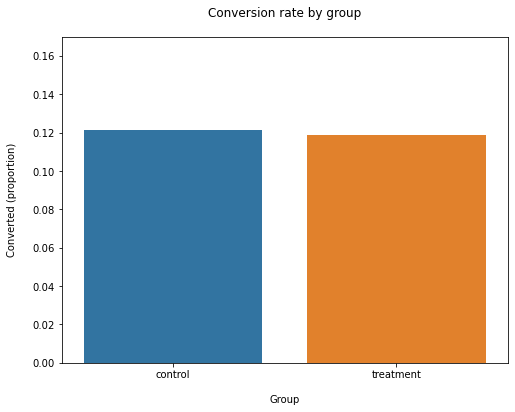

In [44]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

### Implementing Z test

In [47]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]


z statistic: 1.61
p-value: 0.108
ci 95% for control group: [0.119, 0.124]
ci 95% for treatment group: [0.116, 0.121]


In [50]:
#Calculate dhat, the estimated difference between probability of conversions in the experiment and control groups
d_hat = (conversions_treatment / total_users_treatment) - (conversions_control / total_users_control)

In [51]:
d_hat

-0.0015782389853555567

In [48]:
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)



In [49]:
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.61
p-value: 0.108
ci 95% for control group: [0.119, 0.124]
ci 95% for treatment group: [0.116, 0.121]


###  We cannot reject the null hypothesis, since p value is greater than alpha. Also there is no difference in the conversion rate of control group and treatment group ie the new design did not do well